In [1]:
# Import libraries

# System

import os

# Analysis

import numpy as np # Numerical Analysis
import geopandas as gpd
import rasterio # Rasters

# Visualization

import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns

In [2]:
# Definitions

def Save_Geotiff_to_template(array, template_path, save_path):
    '''Saves a numpy array into a geotiff with the same CRS as the template.
    '''            

    # Get metadata from template
    rst = rasterio.open(template_path) # Open template
    meta = rst.meta.copy() # Copy template metadata
    # meta.update(compress='lzw') # Good for integers/categorical rasters
    rst.close()

    with rasterio.open(save_path, 'w+', **meta) as out: # Burn features into raster
        out.write_band(1, array)
        
def plot_raster(template_raster, raster, crs, title = 'TITLE'):
    
    # Plot it

    f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame


    art = ax.pcolormesh(template_raster[0], template_raster[1], raster, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

    f.colorbar(art, ax = ax) # Add colorbar
    ax.set_title(title) # Add title
    ax.set_axis_off()

    # Add basemap

    ctx.add_basemap(ax = ax, 
                           crs = crs, 
                           source=ctx.providers.CartoDB.DarkMatter
                          ) 

    plt.show()

In [3]:
# Load plotting data

raster = np.load('template.npy')

trip = gpd.read_file('DoryTrip.geojson').to_crs('EPSG:26915')

In [4]:
# Get metadata from template
rst = rasterio.open('template.tif') # Open template
meta = rst.meta.copy() # Copy template metadata
# meta.update(compress='lzw') # Good for integers/categorical rasters
rst.close()

In [5]:
# Load Data

band_names = ['full_elevation', 'full_water_and_bridges', 'rasterized_fields']
bands = np.empty(len(band_names), dtype = object)


for i, band_name in enumerate(band_names):
    
    filename = band_name + '.tif'
    
    path = os.path.join('3_processed_data', filename)
    
    # Load that raster

    rast = rasterio.open(path) # Open

    bands[i] = rast.read(1) # Save band

    rast.close() # Close

In [6]:
# Get the slope for the elevation...

# https://livebook.manning.com/book/geoprocessing-with-python/chapter-11/115
# https://gis.stackexchange.com/questions/361837/calculating-slope-of-numpy-array-using-gdal-demprocessing

# This is like the derivative AKA Gradient

elevation = bands[0]/100 # Elevation is also in centimeters
elevation[elevation == 0] = None # Remove any zeros, those are the "no data"
resolution = 10

px, py = np.gradient(elevation, resolution)

slope = np.sqrt(px ** 2 + py ** 2)

slope_deg = np.degrees(np.arctan(slope))

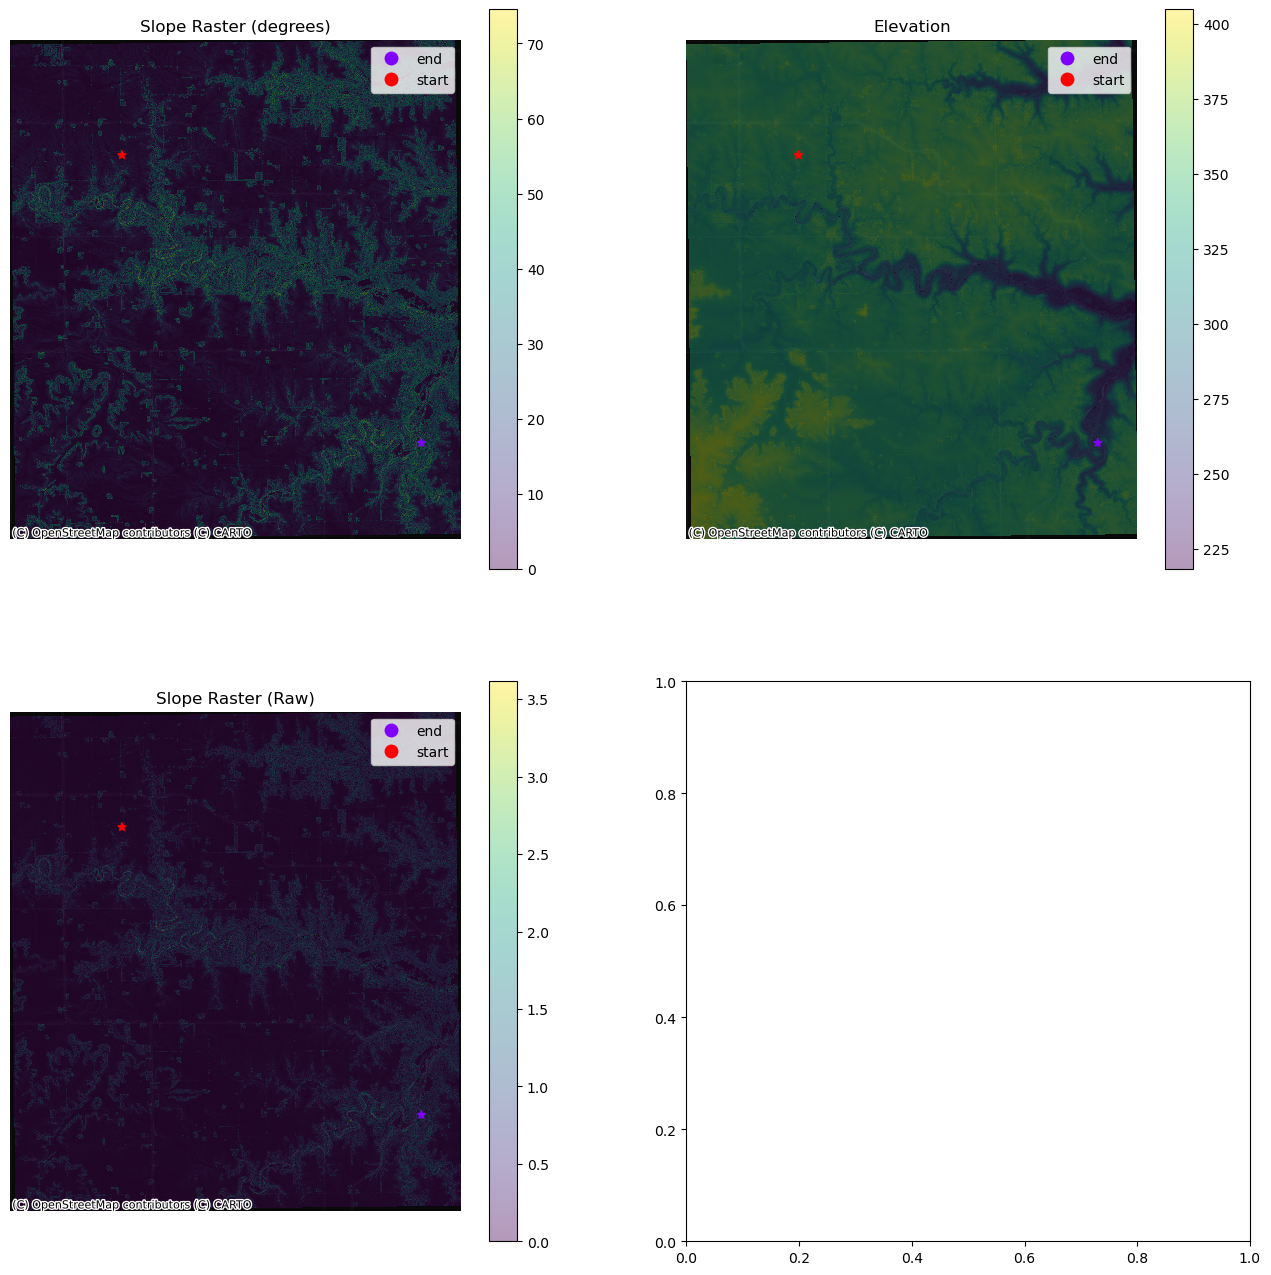

In [7]:
# Plot it

f, axes = plt.subplots(2,2, figsize=(16,16)) # Initialize frame

axs = axes.flatten()

art = axs[0].pcolormesh(raster[0], raster[1], slope_deg.T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = axs[0]) # Add colorbar
title = '''Slope Raster (degrees)'''
axs[0].set_title(title) # Add title
axs[0].set_axis_off()

trip.plot(column = 'type', cmap = 'rainbow', legend = True, marker = '*', ax = axs[0])

# Add basemap

ctx.add_basemap(ax = axs[0], 
                       crs = 'EPSG:26915', 
                       source=ctx.providers.CartoDB.DarkMatter
                      ) 


art = axs[1].pcolormesh(raster[0], raster[1], elevation.T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = axs[1]) # Add colorbar
title = '''Elevation'''
axs[1].set_title(title) # Add title
axs[1].set_axis_off()

trip.plot(column = 'type', cmap = 'rainbow', legend = True, marker = '*', ax = axs[1])

# Add basemap

ctx.add_basemap(ax = axs[1], 
                       crs = 'EPSG:26915', 
                       source=ctx.providers.CartoDB.DarkMatter
                      ) 

art = axs[2].pcolormesh(raster[0], raster[1], slope.T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = axs[2]) # Add colorbar
title = '''Slope Raster (Raw)'''
axs[2].set_title(title) # Add title
axs[2].set_axis_off()

trip.plot(column = 'type', cmap = 'rainbow', legend = True, marker = '*', ax = axs[2])

# Add basemap

ctx.add_basemap(ax = axs[2], 
                       crs = 'EPSG:26915', 
                       source=ctx.providers.CartoDB.DarkMatter
                      ) 


plt.show()


In [8]:
# Well... That's cool

## Standardize

<AxesSubplot: ylabel='Count'>

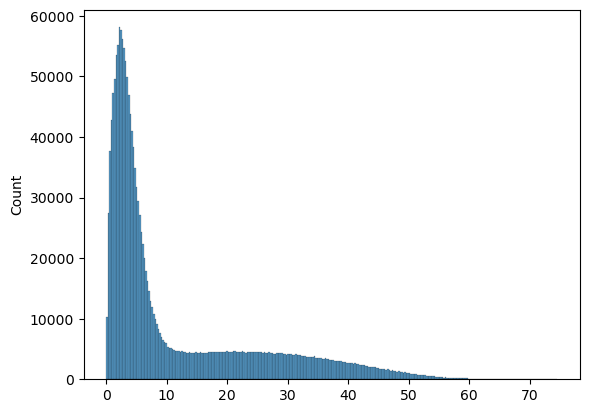

In [9]:
# So raw slope converted to degrees is good. Want to standardize and make it negative (high slope is bad)

sns.histplot(slope_deg.flatten())

/tmp/ipykernel_118282/1316051359.py:3: RuntimeWarning: divide by zero encountered in log
  log_slope = np.log(slope_deg)


<AxesSubplot: ylabel='Count'>

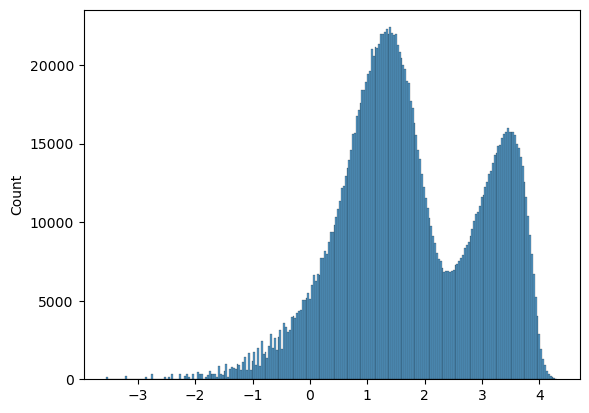

In [10]:
# Pretty heavily tailed... What if we log it?

log_slope = np.log(slope_deg)

sns.histplot(log_slope.flatten())

In [11]:
# Multimodal!

<AxesSubplot: ylabel='Count'>

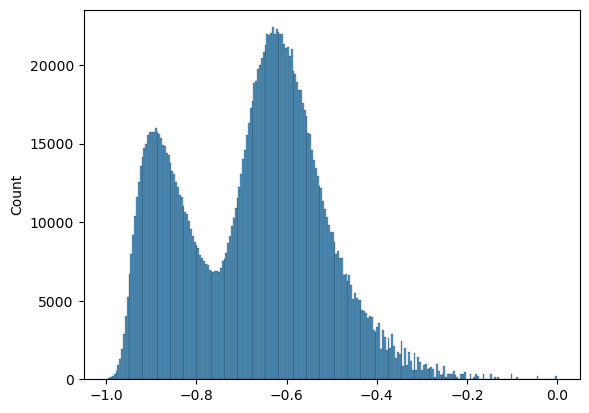

In [12]:
# I'd really like to get into this more, but I'm kind of running outta time.

log_slope = np.log(slope_deg)

# I'm going to standardize this by saying:

non_nan = np.invert(np.isnan(log_slope))
non_neg_inf = np.invert(np.isneginf(log_slope))

non_nan_neg_inf = np.logical_and(non_nan,non_neg_inf)

max_ = log_slope[non_nan_neg_inf].max()
min_ = log_slope[non_nan_neg_inf].min()

shifted_log_slope = log_slope - min_ # Shifting so only positive values

std_log_slope_deg = -(shifted_log_slope/(max_ - min_)) # Normalizing to range and making negative

# Slope of zero (where slope_deg = 0) should be no cost (not infinity)

std_log_slope_deg[slope_deg == 0] = 0

sns.histplot(std_log_slope_deg.flatten())

In [13]:
# Also, I kind of messed up the whole bridges thing. They were just supposed to make a water tile no longer bad. 
# Guess it would've been nice to have Esri's snapping feature...
# Resetting all 1's to zero

std_water = bands[1].copy()

std_water[std_water == 1] = 0

In [14]:
# Want to make the fields boolean negative so we don't have negative weights

std_fields = bands[2].copy()

std_fields = -1*std_fields

In [15]:
# Save them all

folder = '4_std_rasters'

Save_Geotiff_to_template(std_log_slope_deg, 'template.tif', os.path.join(folder, 'std_log_slope_degree.tif'))
Save_Geotiff_to_template(std_water, 'template.tif', os.path.join(folder, 'std_water.tif'))
Save_Geotiff_to_template(std_fields, 'template.tif', os.path.join(folder, 'std_fields.tif'))

